In [ ]:
!pip install opencv-python matplotlib
!apt-get update && apt-get install ffmpeg libsm6 libxext6  -y


Get:1 http://archive.ubuntu.com/ubuntu jammy InRelease [270 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:6 http://archive.ubuntu.com/ubuntu jammy/main amd64 Packages [1792 kB]     
Get:7 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [266 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy/restricted amd64 Packages [164 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [17.5 MB] 
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1196 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [45.2 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1226 kB]

In [3]:
#!pip install torch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0
!pip show torch
!pip show torchvision

Name: torch
Version: 2.5.1+cu124
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /opt/conda/lib/python3.11/site-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: torchaudio, torchelastic, torchvision
Name: torchvision
Version: 0.20.1+cu124
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /opt/conda/lib/python3.11/site-packages
Requires: numpy, pillow, torch
Required-by: 


In [1]:
import torch
import torchaudio
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm

In [2]:
#model = torch.hub.load('pytorch/vision:v0.20.0', 'mobilenet_v2', pretrained=True)
model = models.mobilenet_v2(pretrained=True)
print(model.classifier)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 9.38MB/s]

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [3]:
# Set the output layer to only predict 3 different classes (red, orange, green, black)
NUM_CLASSES=4
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=NUM_CLASSES)

# Freeze the layers
for param in model.features.parameters():
    param.requires_grad = False

print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=4, bias=True)
)


In [9]:
!ls dataset/train

ls: cannot access 'dataset/train': No such file or directory


In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [6]:
# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])


In [10]:
dataset_path = "/workspace/dataset/train"
# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
# Create a DataLoader for batching and shuffling
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
class_labels = dataset.classes
print("Class Labels:", class_labels)

Class Labels: ['back', 'green', 'red', 'yellow']


# Train the model

In [11]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (only train the classifier if earlier layers are frozen)
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

# Scheduler (optional)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [13]:
train_dataset = datasets.ImageFolder(root="/workspace/dataset/train", transform=transform)
val_dataset = datasets.ImageFolder(root="/workspace/dataset/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)  # Validation loader

num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Adjust learning rate if using a scheduler
    if scheduler:
        scheduler.step()

    # Validate after every epoch
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.5074


 10%|█         | 1/10 [00:01<00:13,  1.52s/it]

Validation Loss: 0.5241, Accuracy: 82.25%
Epoch [2/10], Loss: 0.1904


 20%|██        | 2/10 [00:02<00:10,  1.27s/it]

Validation Loss: 0.4291, Accuracy: 85.12%
Epoch [3/10], Loss: 0.1396


 30%|███       | 3/10 [00:03<00:08,  1.20s/it]

Validation Loss: 0.3433, Accuracy: 89.30%
Epoch [4/10], Loss: 0.1258


 40%|████      | 4/10 [00:04<00:06,  1.16s/it]

Validation Loss: 0.2409, Accuracy: 92.17%
Epoch [5/10], Loss: 0.0982


 50%|█████     | 5/10 [00:05<00:05,  1.14s/it]

Validation Loss: 0.2927, Accuracy: 92.17%
Epoch [6/10], Loss: 0.0947


 60%|██████    | 6/10 [00:07<00:04,  1.14s/it]

Validation Loss: 0.2433, Accuracy: 91.64%
Epoch [7/10], Loss: 0.0806


 70%|███████   | 7/10 [00:08<00:03,  1.13s/it]

Validation Loss: 0.2684, Accuracy: 92.43%
Epoch [8/10], Loss: 0.1018


 80%|████████  | 8/10 [00:09<00:02,  1.13s/it]

Validation Loss: 0.2588, Accuracy: 90.86%
Epoch [9/10], Loss: 0.0902


 90%|█████████ | 9/10 [00:10<00:01,  1.14s/it]

Validation Loss: 0.2880, Accuracy: 90.86%
Epoch [10/10], Loss: 0.0972


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]

Validation Loss: 0.2252, Accuracy: 91.12%


In [26]:
!ls /workspace/test_img/test1.jpg

/workspace/test_img/test1.jpg


In [47]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

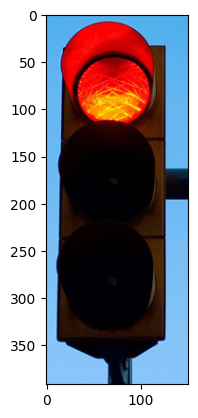

In [45]:
img = cv2.imread("/workspace/test_img/test2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)
plt.imshow(img)

In [46]:
input_tensor = transform(img)
input_tensor = input_tensor.to(device)
output = model(input_tensor.reshape(1, *input_tensor.shape))
output

tensor([[-7.1275, -1.4130, -0.2883, -2.7709]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [50]:
color = ["black", "green", "red", "orange"]
i = np.argmax(output.cpu().detach().numpy()[0])
i, color[i]

(np.int64(2), 'red')

(np.int64(1), 'green')

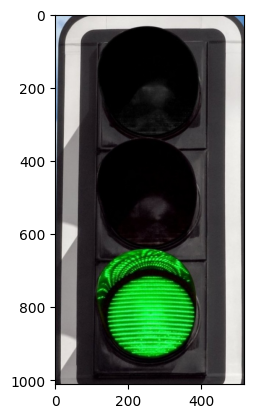

In [51]:
img = cv2.imread("/workspace/test_img/green.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)
plt.imshow(img)
input_tensor = transform(img)
input_tensor = input_tensor.to(device)
output = model(input_tensor.reshape(1, *input_tensor.shape))
i = np.argmax(output.cpu().detach().numpy()[0])
i, color[i]

# Export the model

In [56]:
!mkdir /workspace/model

In [57]:
torch.save(model.state_dict(), "/workspace/model/traffic_light_model.pth")